Add(Mul(Integer(-1), Mul(Integer(5), Symbol('x'))), Add(Mul(Mul(Symbol('y'), Mul(Integer(-1), Pow(Symbol('z'), Integer(2)))), Add(Mul(Integer(-1), Symbol('x')), Symbol('y'))), Mul(Integer(-1), Mul(Integer(2), Add(Symbol('x'), Mul(Integer(-1), Symbol('z')))))))
-1
2
5
{0: (-5.0, 6), 2: (-3.0, 6), 5: (-1.0, 6), 8: (1.0, 6), 10: (3.0, 6), 14: (5.0, 6), 3: (-4.124236071369923, 5), 7: (-0.9617057351211532, 5), 12: (1.1378787822789076, 5), 15: (3.4519665897316525, 5), 1: (-2.686823235838342, 4), 11: (2.5693050257286427, 4), 4: (0.3817002897634577, 3), 6: (1.310094086097353, 2), 9: (0.9411783037999689, 1), 13: (0.493695188367684, 0)}


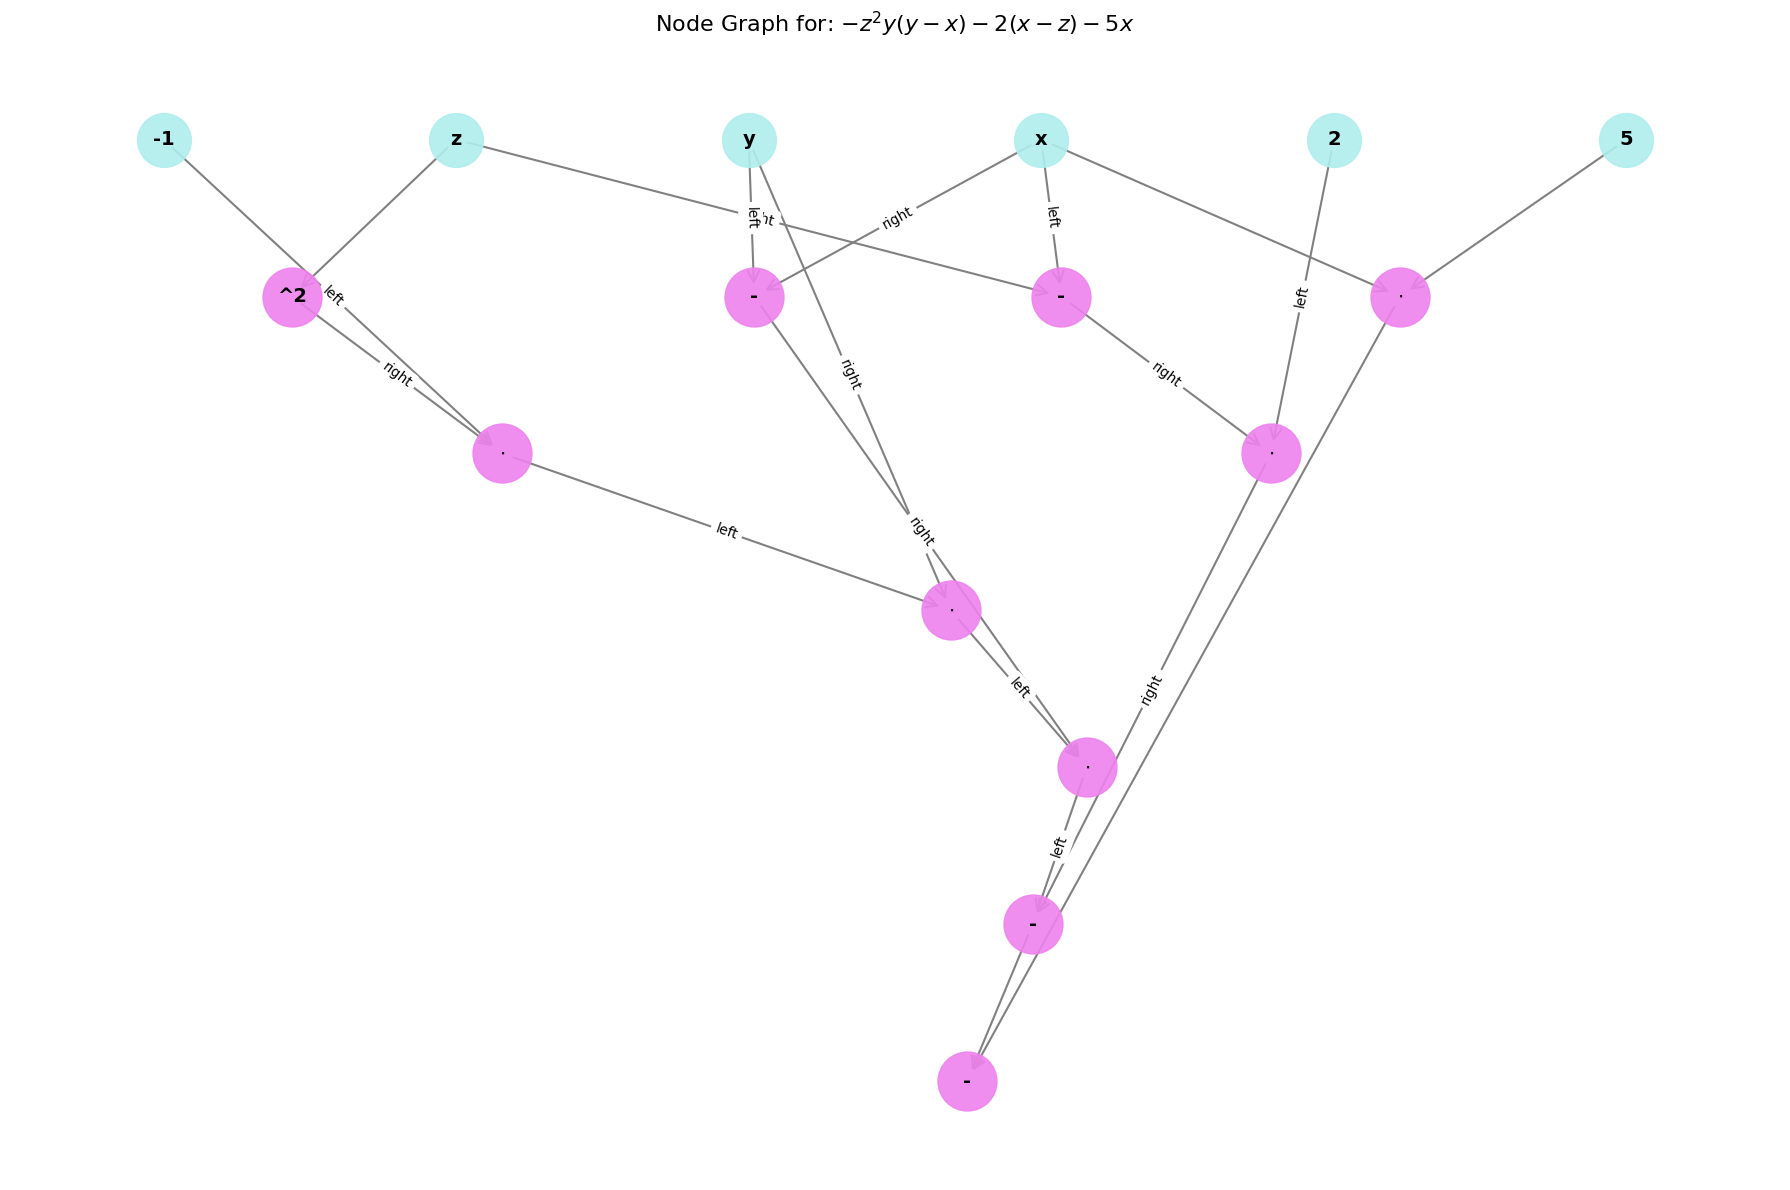

In [259]:
import sympy as sp
import networkx as nx
import matplotlib.pyplot as plt
from sympy.parsing.sympy_parser import parse_expr, standard_transformations, implicit_multiplication_application
from collections import deque, defaultdict
import numpy as np
import random
import ast


class PolynomialParser(ast.NodeVisitor):
    def visit_BinOp(self, node):
        left = self.visit(node.left)
        right = self.visit(node.right)
        op = type(node.op)

        if op == ast.Add:
            return sp.Add(left, right, evaluate=False)
        elif op == ast.Sub:
            return sp.Add(left, sp.Mul(-1, right, evaluate=False), evaluate=False)
        elif op == ast.Mult:
            return sp.Mul(left, right, evaluate=False)
        elif op == ast.Pow:
            return sp.Pow(left, right, evaluate=False)
        
    def visit_UnaryOp(self, node):
        operand = self.visit(node.operand)
        if isinstance(node.op, ast.USub):  # Unary minus: -x
            return sp.Mul(-1, operand, evaluate=False)
    
    def visit_Name(self, node):
        return sp.Symbol(node.id)

    def visit_Constant(self, node): 
        return sp.Number(node.value)

    def visit_Expr(self, node):
        return self.visit(node.value)
    
    def parse(self, expression):
        tree = ast.parse(expression, mode='eval')
        raw_expr = self.visit(tree.body)
        return raw_expr
    


# Parse a sympy expression and build a node graph showing operations
def create_node_graph(expr):
    graph = nx.DiGraph()
    node_id = 0
    node_id, root_id = process_expression(expr, graph, node_id)
    return graph, root_id


# Process the expression recursively
def process_expression(expr, graph, node_id, parent_id=None, top_level=False, expr_to_id=None):
    if expr_to_id is None:
        expr_to_id = {}
    
    # Checks if the exact expression has been processed and does not add it if so
    # Uses hash to create a unique key for each expression element
    expr_hash = hash(expr)
    if expr_hash in expr_to_id:
        node_for_expr = expr_to_id[expr_hash]
        if parent_id is not None:
            graph.add_edge(node_for_expr, parent_id)

        return node_id, node_for_expr
    
    if isinstance(expr, sp.Add) or isinstance(expr, sp.Mul):
        args = list(expr.args)
        
        if top_level:
            # if top_level = True the first time this function executes, there is a non binary addition as the last addition in the sequence of polynomials
            add_node = node_id
            graph.add_node(add_node, label="+" if isinstance(expr, sp.Add) else r"$\cdot$", type="operation")
            expr_to_id[expr_hash] = add_node
            node_id += 1
            
            # Process each term in the top-level expression
            for term in args:
                node_id, child_id = process_expression(term, graph, node_id, add_node, top_level=False, expr_to_id=expr_to_id)
            
            if parent_id is not None:
                graph.add_edge(add_node, parent_id)
            return node_id, add_node
        else:
            # Creates a binary tree for addition/multiplication
            if isinstance(expr, sp.Add):
                label = "+"
            else:
                label = r"$\cdot$"
                
            if len(args) > 0:
                left_expr = args[0]
                node_id, left_id = process_expression(left_expr, graph, node_id, top_level=False, expr_to_id=expr_to_id)
        
                for i in range(1, len(args)):
                    expr_branch = args[i]
                    
                    if isinstance(expr, sp.Add) and expr_branch.could_extract_minus_sign():
                        # For addition with negative term, create a subtraction node instead
                        parent_node = node_id
                        graph.add_node(parent_node, label="-", type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label = 'left')
                        
                        # Right branch is the term without the negative sign
                        node_id, right_id = process_expression(-expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label = 'right')
                    else:
                        # Standard addition or multiplication node
                        parent_node = node_id
                        graph.add_node(parent_node, label=label, type="operation")
                        expr_to_id[expr_hash] = parent_node
                        node_id += 1
                        
                        # Connect to the parent node if exists
                        if parent_id is not None:
                            graph.add_edge(parent_node, parent_id)
                            parent_id = parent_node
                        
                        # Left branch is the result so far
                        graph.add_edge(left_id, parent_node, label = 'left')
                        
                        # Right branch is the current term
                        node_id, right_id = process_expression(expr_branch, graph, node_id, top_level=False, expr_to_id=expr_to_id)
                        graph.add_edge(right_id, parent_node, label = 'right')
                    
                    left_id = parent_node  # for chaining operations
                
                return node_id, left_id
            else:
                # Handle empty args case (unlikely but for robustness)
                return node_id, None
    elif isinstance(expr, sp.Pow):
        base, exp = expr.args
        # Assumes that exponent is an integer
        if exp.is_Integer and exp > 1:
            # Process the base expression once
            node_id, base_id = process_expression(base, graph, node_id, top_level=False, expr_to_id=expr_to_id)
            
            # Create the power node
            pow_node = node_id
            graph.add_node(pow_node, label=f"^{exp}", type="operation")
            expr_to_id[expr_hash] = pow_node
            node_id += 1
            
            # Connect the nodes
            graph.add_edge(base_id, pow_node)
            
            if parent_id is not None:
                graph.add_edge(pow_node, parent_id)
                
            return node_id, pow_node
            
    elif isinstance(expr, sp.Symbol):
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    elif expr.is_number:
        curr_id = node_id
        print(expr)
        # Display negative numbers directly with the negative sign
        graph.add_node(curr_id, label=str(round(expr, 2)), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id
    
    # Handle standalone negative terms (like -x or -x^2)
    elif expr.could_extract_minus_sign():
        # For terms with negative coefficients that are not numbers or symbols
        neg_expr = -expr  # Get the positive version
        
        # Check if this is a simple term with a negative coefficient
        if isinstance(neg_expr, sp.Mul) and any(arg.is_number and arg > 0 for arg in neg_expr.args):
            # This is a term with a negative coefficient
            # Create a node with the negative coefficient included directly
            curr_id = node_id
            graph.add_node(curr_id, label=str(expr), type="value")
            expr_to_id[expr_hash] = curr_id
            node_id += 1
            if parent_id is not None:
                graph.add_edge(curr_id, parent_id)
            return node_id, curr_id
        else:
            # For more complex negative expressions, use a negation node
            neg_node = node_id
            graph.add_node(neg_node, label="-", type="operation")
            expr_to_id[expr_hash] = neg_node
            node_id += 1
            
            # Process the positive version
            node_id, pos_id = process_expression(neg_expr, graph, node_id, top_level=False, expr_to_id=expr_to_id)
            graph.add_edge(pos_id, neg_node)
            
            if parent_id is not None:
                graph.add_edge(neg_node, parent_id)
                
            return node_id, neg_node
    
    else:
        # Default case for any other expression types
        curr_id = node_id
        graph.add_node(curr_id, label=str(expr), type="value")
        expr_to_id[expr_hash] = curr_id
        node_id += 1
        if parent_id is not None:
            graph.add_edge(curr_id, parent_id)
        return node_id, curr_id



# Orders nodes based on stages starting from the symbolic characters
def stage_levels(G, node):
    levels = {}
    for node in nx.topological_sort(G):
        preds = list(G.predecessors(node))
        if not preds:
            levels[node] = 0
        else:
            levels[node] = max(levels[p] + 1 for p in preds)
    return levels

def math_levels(G, root):
    nodes_math_level = {}
    added_levels = 0
    
    nodes_by_level = organise_nodes_by_level(stage_levels(G, root))
    for level, nodes in nodes_by_level.items():
        if level == 0:
            for j in nodes:
                nodes_math_level[j] = level
        else:
            if not all(G.nodes[nodes[0]]['label'] == G.nodes[x]['label'] for x in nodes):
                added_levels += 1
                for j in nodes:
                    if(G.nodes[j]['label'] == '+'):
                        nodes_math_level[j] = level + added_levels - 1
                    elif(G.nodes[j]['label'] == '$\\cdot$'):
                        nodes_math_level[j] = level + added_levels
            else:
                for k in nodes:
                    nodes_math_level[k] = level + added_levels

    return nodes_math_level

def organise_nodes_by_level(levels):
    nodes_by_level = {}
    
    for node, level in levels.items():
        if level not in nodes_by_level:
            nodes_by_level[level] = []
        nodes_by_level[level].append(node)

    return {k: v for k, v in sorted(nodes_by_level.items())}

def custom_layout(G, root):
    pos = {}
    
    levels = stage_levels(G, root)
    #levels = math_levels(G, root)
    nodes_by_level = organise_nodes_by_level(levels)
    
    for level in nodes_by_level:
        nodes_by_level[level].sort(key=lambda n: (G.nodes[n].get('type', ''), G.nodes[n].get('label', '')))
    
    max_level = max(nodes_by_level)
    spacing = 2 
    
    for level, nodes in nodes_by_level.items():
        num_nodes = len(nodes)
        
        if level == 0:
            max_span = (num_nodes - 1) * spacing    
            x_start = -max_span / 2
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * spacing
                y = max_level - level
                pos[node] = (x, y)
                
        else:
            if(num_nodes == 1):
                x_start =  random.uniform(-1.5, 1.5)
            else:
                span = (num_nodes - 1) * (max_span/num_nodes)
                x_start = - span/ 2
                
            for i, node in enumerate(sorted(nodes)):
                x = x_start + i * (max_span/num_nodes) + random.uniform(-0.5, 0.5)
                y = max_level - level
                pos[node] = (x, y)     
    print(pos)
    
    return pos
    
    

def visualize_polynomial(polynomial_str):
    # Parse the expression
    parser = PolynomialParser()
    expr = parser.parse(polynomial_str)
    print(sp.srepr(expr))
    graph, root_id = create_node_graph(expr)
    node_labels = nx.get_node_attributes(graph, 'label')
    pos = custom_layout(graph, root_id)
    
    plt.figure(figsize=(18, 12))
    
    #Divide up the nodes
    operation_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'operation']
    value_nodes = [n for n in graph.nodes() if graph.nodes[n].get('type') == 'value']

    nx.draw_networkx_edges(graph, pos, arrows=True, arrowstyle='->', arrowsize=20, width=1.5, edge_color='gray')
    
    nx.draw_networkx_nodes(graph, pos, nodelist=operation_nodes, node_size=1800, node_color='violet', alpha=0.9)
    
    nx.draw_networkx_nodes(graph, pos, nodelist=value_nodes, node_size=1500, node_color='paleturquoise', alpha=0.9)

    edge_labels = nx.get_edge_attributes(G, 'label')

# Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    
    
    node_id_labels = {node: str(node) for node in graph.nodes()}
    #nx.draw_networkx_labels(graph, pos, labels=node_id_labels, font_size=12, font_weight='bold')
    nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=14, font_weight='bold')
    
    plt.title(f"Node Graph for: ${(polynomial_str.replace('**', '^')).replace('*', '')}$", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show() 

    return graph, root_id


#user_input = input("\nEnter a polynomial: ")
user_input = "-x^2 + 4*x^2 + 5.3*((x*y) - z) - 1.01*y*(x+z) + 1.3*(x+ y) - 2.1*((x+y)^2 + z)"
#user_input = "3.2*(x*(4.2*(x*1.2*(x+1)+2)+4)+5)"
# user_input = "x*y + ((w+x)*y + z) - 2.3*((x+y)^2 + z) + 3*(x*y-w)"
# # user_input = "z^2 + (w+x)*y + z"
# user_input = "(z+1)*z - 2.3*(w-x)*y"
user_input = "-z^2*y*(y-x) - 2*(x-z) - 5*x"


if user_input.strip():
    user_input = user_input.replace('^', '**')
    G, root = visualize_polynomial(user_input)


In [248]:
class PolynomialParser(ast.NodeVisitor):
    def visit_BinOp(self, node):
        left = self.visit(node.left)
        right = self.visit(node.right)
        op = type(node.op)

        if op == ast.Add:
            return sp.Add(left, right, evaluate=False)
        elif op == ast.Sub:
            return sp.Add(left, sp.Mul(sp.Integer(-1), right, evaluate=False), evaluate=False)
        elif op == ast.Mult:
            return sp.Mul(left, right, evaluate=False)
        elif op == ast.Pow:
            return sp.Pow(left, right, evaluate=False)

    def visit_UnaryOp(self, node):
        operand = self.visit(node.operand)
        if isinstance(node.op, ast.USub):  # -x
            if isinstance(operand, sp.Number):
                return sp.Number(-operand)
            return sp.Mul(sp.Integer(-1), operand, evaluate=False)

    def visit_Name(self, node):
        return sp.Symbol(node.id)

    def visit_Constant(self, node): 
        value = node.value
        if isinstance(value, float) and value < 0:
            return sp.Float(value, precision=53)
        return sp.Number(value)

    def visit_Expr(self, node):
        return self.visit(node.value)

    def int_to_float(self, expr):
        if isinstance(expr, sp.Mul):
            return sp.Mul(*[self.int_to_float(a) for a in expr.args], evaluate=False)
        elif isinstance(expr, sp.Add):
            return sp.Add(*[self.int_to_float(a) for a in expr.args], evaluate=False)
        elif isinstance(expr, sp.Pow):
            return sp.Pow(self.int_to_float(expr.args[0]), self.int_to_float(expr.args[1]), evaluate=False)
        elif isinstance(expr, sp.Integer):
            return sp.Float(float(expr), precision=53)
        elif expr.is_Atom:
            return expr
        else:
            return expr.func(*[self.int_to_float(a) for a in expr.args], evaluate=False)

    def parse(self, expression):
        tree = ast.parse(expression, mode='eval')
        raw_expr = self.visit(tree.body)
        raw_expr = self.int_to_float(raw_expr)
        return raw_expr

    

user_input = "-2.3*(w-x)*y - 2*x"
#user_input = "-2.3*x"
parser = PolynomialParser()
expr = parser.parse(user_input)
print(expr)
print(sp.srepr(expr))


-2.0*x + y*(-2.3*(w - 1.0*x))
Add(Mul(Integer(-1), Float('1.0', precision=53), Mul(Float('2.0', precision=53), Symbol('x'))), Mul(Symbol('y'), Mul(Integer(-1), Float('2.2999999999999998', precision=53), Add(Symbol('w'), Mul(Integer(-1), Float('1.0', precision=53), Symbol('x'))))))


In [250]:
graph = nx.DiGraph()
node_id = 0
node_id, root_id = process_expression(expr, graph, node_id)
print(graph)

-2.30000000000000
1.00000000000000
2.00000000000000
DiGraph with 13 nodes and 14 edges


In [235]:
from sympy import Integer, Float, Mul, Add, Symbol, sympify

def process_mul(node):
    if not isinstance(node, Mul):
        return node
    neg_ones = []
    floats = []
    others = []
    for arg in node.args:
        if arg.is_Integer and arg == Integer(-1):
            neg_ones.append(arg)
        elif isinstance(arg, Float):
            floats.append(arg)
        else:
            others.append(arg)
    if not neg_ones or not floats:
        return node
    sign = (-1) ** len(neg_ones)
    float_product = Mul(*floats) if len(floats) > 1 else floats[0]
    new_float = sign * float_product
    new_args = [new_float] + others
    print("here")
    print(Mul(*new_args, evaluate=False))
    return Mul(*new_args, evaluate=False)

def transform_expr(expr):
    if isinstance(expr, (Add, Mul)):
        new_args = [transform_expr(arg) for arg in expr.args]
        new_expr = expr.func(*new_args)
        if isinstance(new_expr, Mul):
            return process_mul(new_expr)
        else:
            return new_expr
    else:
        return expr

# Example usage with the given srepr
expr = Add(
    Mul(Integer(-1), Float('2.0', precision=53), Symbol('x'), evaluate=False),
    Mul(
        Integer(-1), Float('2.2999999999999998', precision=53),
        Symbol('y'), Add(Symbol('w'), Mul(Integer(-1), Symbol('x'), evaluate=False)),
        evaluate=False
    )
)

transformed_expr = transform_expr(expr)
print(transformed_expr)
print(sp.srepr(transformed_expr))

-2.0*x - 2.3*y*(w - x)
Add(Mul(Integer(-1), Float('2.0', precision=53), Symbol('x')), Mul(Integer(-1), Float('2.2999999999999998', precision=53), Symbol('y'), Add(Symbol('w'), Mul(Integer(-1), Symbol('x')))))


In [ ]:
levels = {}
for node in G.nodes():
    layer = 0

    #Nodes that have nothing pointing to them, set level to 0
    in_degree = G.in_degree(node)

    if in_degree == 0:
        queue = [node]
        levels[node] = layer
        print(levels)
        layer = 1
    
        #Connected nodes have layer one higher
        while queue:
            print("layer: ", layer)
            print(queue)
            for i in list(G.successors(queue.pop())):
                if i in levels.keys():
                    print("in")
                    if levels[i] < layer:
                        levels[i] = layer
                else:
                    levels[i] = layer
                print(levels)
                
                queue.append(i)
                
            layer += 1

print(levels)


{0: 0}
layer:  1
[0]
{0: 0, 1: 1}
{0: 0, 1: 1, 5: 1}
{0: 0, 1: 1, 5: 1, 12: 1}
layer:  2
[1, 5, 12]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2}
layer:  3
[1, 5, 13]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3}
layer:  4
[1, 5, 14]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4}
layer:  5
[1, 5, 11]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5}
layer:  6
[1, 5, 9]
layer:  7
[1, 5]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7}
layer:  8
[1, 6]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7, 7: 8}
layer:  9
[1, 7]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 5, 6: 7, 7: 8, 3: 9}
layer:  10
[1, 3]
in
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 10, 6: 7, 7: 8, 3: 9}
layer:  11
[1, 9]
layer:  12
[1]
in
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 10, 6: 7, 7: 8, 3: 12}
layer:  13
[3]
in
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 13, 6: 7, 7: 8, 3: 12}
layer:  14
[9]
{0: 0, 1: 1, 5: 1, 12: 1, 13: 2, 14: 3, 11: 4, 9: 13, 6: 7, 7: 8, 3: 12, 2: 0}
layer:  1
[

In [97]:
levels = {}
for node in nx.topological_sort(G):
    preds = list(G.predecessors(node))
    if not preds:
        levels[node] = 0
    else:
        levels[node] = max(levels[p] + 1 for p in preds)

print(levels)

{0: 0, 2: 0, 4: 0, 8: 0, 10: 0, 1: 1, 12: 1, 5: 1, 13: 2, 6: 2, 14: 3, 7: 3, 11: 4, 3: 4, 9: 5}


In [ ]:
 def absorb_negatives(self, expr):
        if isinstance(expr, sp.Mul):
            args = list(expr.args)

            # Check for negative integer (-1) in the multiplication
            if sp.Integer(-1) in args:
                args.remove(sp.Integer(-1))  # Remove the -1

                # Process each argument for negative signs
                for i, arg in enumerate(args):
                    if isinstance(arg, sp.Float):
                        # If it's a float, negate it manually
                        args[i] = sp.Float(-float(arg), precision=arg._prec)
                    elif isinstance(arg, sp.Integer):
                        # If it's an integer, convert it to a negative float
                        args[i] = sp.Float(-float(arg), precision=53)

                # Now construct the multiplication with the modified arguments
                return sp.Mul(*args, evaluate=False)

            # If no -1 found, process the arguments normally
            return sp.Mul(*[self.absorb_negatives(a) for a in args], evaluate=False)

        # If it's an addition, process the arguments
        elif isinstance(expr, sp.Add):
            return sp.Add(*[self.absorb_negatives(a) for a in expr.args], evaluate=False)

        # If it's a power, process the base and exponent
        elif isinstance(expr, sp.Pow):
            return sp.Pow(self.absorb_negatives(expr.args[0]), self.absorb_negatives(expr.args[1]), evaluate=False)

        # If it's an atom, return as is
        elif expr.is_Atom:
            return expr

        # For other functions, process them recursively
        else:
            return expr.func(*[self.absorb_negatives(a) for a in expr.args], evaluate=False)

            
                